In [341]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [759]:
# Scientific Computing
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.stats import pearsonr

import bottleneck as bn

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import gsw

from deformtools.tools import *
from deformtools.io import *
from deformtools.methods import *


# sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
# from spectra_module import spec2d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [198]:
# %% MAIN
data_path = '../data/'
zgrid_path = data_path+'psom/zgrid.out'
model_path = data_path+'psom/full_08325.cdf'

# dat = read_model_field(snakemake.input[0], snakemake.input[1])
dat = read_model_field(zgrid_path, model_path) 
dat = dat.rename({'xc':'x'}).rename({'yc':'y'})
dat = dat.set_coords({'x','y'}).transpose('x','y')

fu_list, fv_list, fzeta_list = filter_fields(dat)

In [340]:
dat

<xarray.Dataset>
Dimensions:   (x: 194, y: 322)
Coordinates:
  * x         (x) float64 -0.5 0.5 1.5 2.5 3.5 ... 188.5 189.5 190.5 191.5 192.5
  * y         (y) float64 -0.5 0.5 1.5 2.5 3.5 ... 316.5 317.5 318.5 319.5 320.5
Data variables:
    u         (x, y) float64 ...
    v         (x, y) float64 ...
    vor       (x, y) float64 ...
    vor_5km   (x, y) float64 2.669e-05 2.203e-05 ... 3.852e-05 3.17e-05
    u_5km     (x, y) float64 -0.1698 -0.1303 -0.09107 ... -0.2343 -0.2036
    v_5km     (x, y) float64 0.02166 0.0233 0.02508 ... 0.01329 0.01488 0.01687
    vor_10km  (x, y) float64 2.568e-05 2.423e-05 ... 2.778e-05 2.675e-05
    u_10km    (x, y) float64 -0.06762 -0.06398 -0.05933 ... -0.06731 -0.06598
    v_10km    (x, y) float64 0.006158 0.006635 0.006994 ... 0.005122 0.005764

In [426]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [493]:
xi, yi = make_n_hexs(0.1, 1, 1, 6)

fu=fu_list[0]
fv=fv_list[0]
fzeta=fzeta_list[0]
# find the u,v at the polygon vertices
ui = fu.ev(xi, yi)
vi = fv.ev(xi, yi)
zeta = fzeta.ev(xi, yi)

In [527]:
f= gsw.f(17)

dt=1

urot = vi
vrot = ui

xi_n = xi + dt*urot/1000
yi_n = yi + dt*vrot/1000
points = np.squeeze( np.array( [xi, yi] ) ).T
points_n = np.squeeze( np.array( [xi_n, yi_n] ) ).T

hull = ConvexHull(points)
hull_n = ConvexHull(points_n)
area = ConvexHull(points).area
area_n = ConvexHull(points_n).area

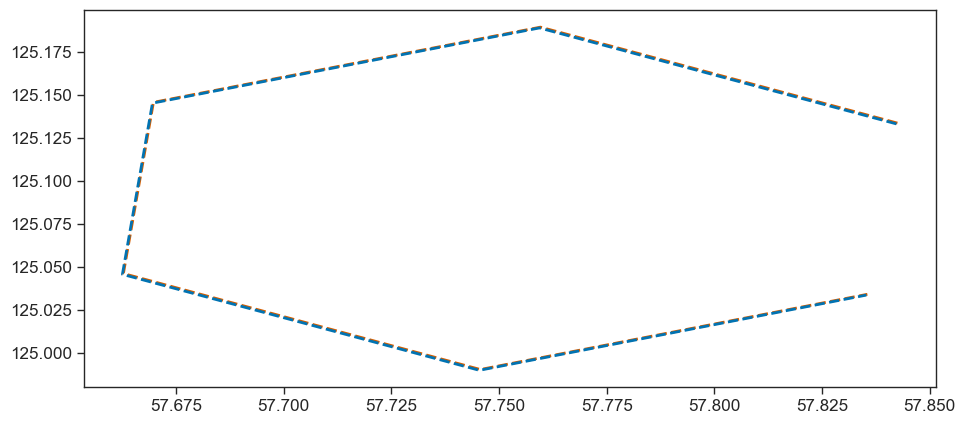

In [528]:
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points_n[hull_n.vertices,0], points_n[hull_n.vertices,1], 'b--', lw=2)

In [587]:
def saucier(x,y,u,v):
    f= gsw.f(17)

    dt=0.1

    urot = v
    vrot = -u

    xi_n = x + dt*urot/1000
    yi_n = y + dt*vrot/1000
    points = np.squeeze( np.array( [x, y] ) ).T
    points_n = np.squeeze( np.array( [xi_n, yi_n] ) ).T

    hull = ConvexHull(points)
    hull_n = ConvexHull(points_n)
    area = ConvexHull(points).area
    area_n = ConvexHull(points_n).area
    
    return (area_n - area)/area/dt/f

In [713]:
def kawai(x,y,u,v):
    f= gsw.f(17)
    uvec = np.append(u,u[0])
    vvec = np.append(v,v[0])
    xvec = np.append(x,x[0])
    yvec = np.append(y,y[0])

    umean = np.array( [np.mean(uvec[i:i+2]) for i in range(u.size) ])
    vmean = np.array( [np.mean(vvec[i:i+2]) for i in range(v.size) ])

    rx = np.array( [ xvec[i+1]-xvec[i] for i in range(x.size) ])*1000
    ry = np.array( [ yvec[i+1]-yvec[i] for i in range(y.size) ])*1000
    
    points = np.squeeze( np.array( [x, y] ) ).T
    area = ConvexHull(points).area

    return np.sum( umean*rx + vmean*ry )/f/(1e6*area)

In [754]:
f= gsw.f(17)
N=10000
M=6
L=1
S=1
xi, yi = make_n_hexs(L, S, N, M)

fu=fu_list[0]
fv=fv_list[0]
fzeta=fzeta_list[0]
# find the u,v at the polygon vertices
ui = fu.ev(xi, yi)
vi = fv.ev(xi, yi)
zeta = fzeta.ev(xi, yi)

LS=[]
SAU = []
TRUE = []
KAW = []
for i in range(N):
    LS.append( least_square_method( xi[i,:], yi[i,:], ui[i,:], vi[i,:], 'lstsq'))
    SAU.append( saucier(xi[i,:], yi[i,:], ui[i,:], vi[i,:]))
    TRUE.append( np.nanmean( zeta[i,:])/f)
    KAW.append( kawai(xi[i,:], yi[i,:], ui[i,:], vi[i,:]))
    
LS = np.array(LS).squeeze()[:,0]
SAU = np.array(SAU)
TRUE = np.array(TRUE)
KAW = np.array(KAW)

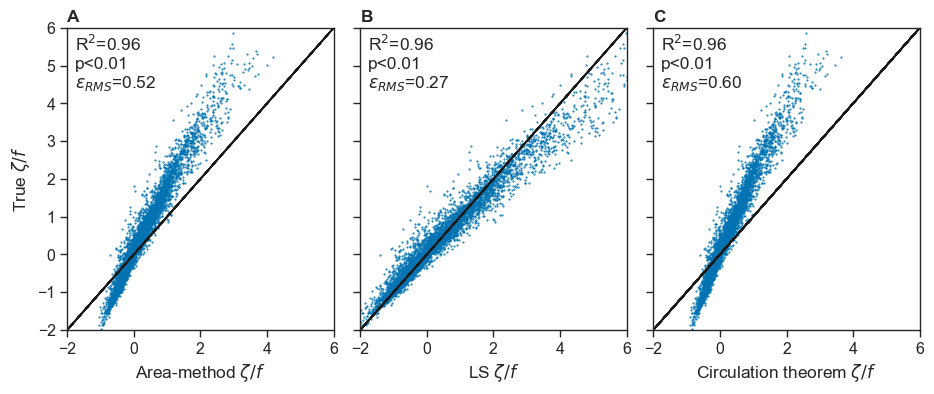

In [795]:
fig,ax = plt.subplots(1,3, sharey=True,figsize=(11,4))
ax[0].plot(SAU,TRUE,'.', markersize=1)
ax[0].plot(TRUE,TRUE,color='k')
ax[0].set_ylim(-2,6)
ax[0].set_xlim(-2,6)
ax[0].set_ylabel('True $\zeta/f$')
ax[0].set_xlabel('Area-method $\zeta/f$')

r,p = pearsonr(SAU, TRUE)
e = np.sqrt( np.mean( (SAU-TRUE)**2 ) )
r2=r**2
ax[0].annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.01'+'\n'+rf'$\epsilon_{{RMS}}$={e:2.2f}',(0.03,0.8),xycoords='axes fraction')


ax[1].plot(LS,TRUE,'.', markersize=1)
ax[1].plot(TRUE,TRUE,color='k')
ax[1].set_ylim(-2,6)
ax[1].set_xlim(-2,6)
ax[1].set_xlabel('LS $\zeta/f$')

r,p = pearsonr(LS, TRUE)
e = np.sqrt( np.mean( (LS-TRUE)**2 ) )
r2=r**2
ax[1].annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.01'+'\n'+rf'$\epsilon_{{RMS}}$={e:2.2f}',(0.03,0.8),xycoords='axes fraction')

ax[2].plot(KAW,TRUE,'.', markersize=1)
ax[2].plot(TRUE,TRUE,color='k')
ax[2].set_ylim(-2,6)
ax[2].set_xlim(-2,6)
ax[2].set_xlabel('Circulation theorem $\zeta/f$')

r,p = pearsonr(KAW, TRUE)
e = np.sqrt( np.mean( (KAW-TRUE)**2 ) )
r2=r**2
ax[2].annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.01'+'\n'+rf'$\epsilon_{{RMS}}$={e:2.2f}',(0.03,0.8),xycoords='axes fraction')

plt.subplots_adjust(wspace=0.1)

alphabet(ax)

plt.savefig('../figures/compare_methods.pdf',dpi=600)